<a href="https://colab.research.google.com/github/vanecornejo/EDP-II/blob/main/Richardson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ecuación de calor: método de Richardson




Uno de nuestros objetivos es Implementar la extrapolación de Richardson y usarla para mejorar aproximaciones para estimar orden empírico de convergencia y documentar los resultados.


In [9]:

# Importamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isfinite


## Breve teoría
Si una aproximación numérica $A(h)$ al valor exacto $A$ satisface
$$ A(h) = A + c h^p + O(h^{p+1}), $$
entonces, usando $A(h)$ y $A(\frac{h}{2})$ podemos cancelar el término del error:
$$ A_R = A(\frac{h}{2}) + \frac{A(\frac{h}{2}) - A(h)}{2^p - 1}, $$
obteniendo una aproximación de orden superior.


In [10]:
# Definimos las funciones numéricas

# Diferencia hacia adelante
def forward_diff(f, x, h):
    return (f(x + h) - f(x)) / h

# Diferencia centrada
def central_diff(f, x, h):
    return (f(x + h) - f(x - h)) / (2*h)

# Regla trapezoidal, paso h = (b-a)/n
def trapezoidal_rule(f, a, b, n):
    x = np.linspace(a, b, n+1)
    y = f(x)
    h = (b - a) / n
    return (h/2) * (y[0] + 2*y[1:-1].sum() + y[-1])

# Extrapolación de Richardson para dos aproximaciones
def richardson_extrapolate(A_h, A_h2, p):
    return A_h2 + (A_h2 - A_h) / (2**p - 1)

# Estimación de eroor
def estimated_order_from_errors(e1, e2, h1, h2):
    if e1 == 0 or e2 == 0 or not (isfinite(e1) and isfinite(e2)):
        return np.nan
    return np.log(abs(e1)/abs(e2)) / np.log(abs(h1)/abs(h2))



## Ejemplo 1:
Tenemos
$f(x)=\sin(x)$ en $x_0=\frac{\pi}{4}$

Derivada exacta: $f'(x)=\cos(x),$ por lo tanto $f'(\pi/4)=\sqrt{2}/2 $.
Usaremos diferencias hacia adelante (orden 1) y diferencias centrales (orden 2), y aplicaremos Richardson.


In [11]:

# Función y punto de evaluación
def f(x):
    return np.sin(x)
x0 = np.pi / 4
derivada_exacta = np.cos(x0)

# H's a probar: h = 2^-k
k_vals = np.arange(1, 11)
h_vals = 2.0 ** (-k_vals)

results = []
for h in h_vals:
    fd_h = forward_diff(f, x0, h)
    fd_h2 = forward_diff(f, x0, h/2)
    cd_h = central_diff(f, x0, h)
    cd_h2 = central_diff(f, x0, h/2)

    rich_fd = richardson_extrapolate(fd_h, fd_h2, p=1)   # forward O(h) -> p=1
    rich_cd = richardson_extrapolate(cd_h, cd_h2, p=2)   # central O(h^2) -> p=2

    err_fd = abs(fd_h - derivada_exacta)
    err_fd_r = abs(rich_fd - derivada_exacta)
    err_cd = abs(cd_h - derivada_exacta)
    err_cd_r = abs(rich_cd - derivada_exacta)

    results.append({
        'h': h,
        'forward': fd_h,
        'err_forward': err_fd,
        'forward_richardson': rich_fd,
        'err_forward_r': err_fd_r,
        'central': cd_h,
        'err_central': err_cd,
        'central_richardson': rich_cd,
        'err_central_r': err_cd_r
    })

df = pd.DataFrame(results)
df_display = df.copy()
float_cols = [c for c in df_display.columns if c.startswith('err') or c in ['h','forward','forward_richardson','central','central_richardson']]
df_display[float_cols] = df_display[float_cols].applymap(lambda x: float(f"{x:.6e}"))
df_display.head(10)


/tmp/ipython-input-2181416500.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_display[float_cols] = df_display[float_cols].applymap(lambda x: float(f"{x:.6e}"))


,h,forward,err_forward,forward_richardson,err_forward_r,central,err_central,central_richardson,err_central_r
0,0.500000,0.504886,0.202221,0.718785,1.167776e-02,0.678010,2.909668e-02,0.707015,9.138863e-05
1,0.250000,0.611835,0.095272,0.710425,3.318371e-03,0.699764,7.342712e-03,0.707101,5.743756e-06
2,0.125000,0.661130,0.045977,0.707983,8.763234e-04,0.705267,1.839986e-03,0.707106,3.594859e-07
3,0.062500,0.684557,0.022550,0.707332,2.247054e-04,0.706646,4.602661e-04,0.707107,2.247571e-08
4,0.031250,0.695944,0.011163,0.707164,5.686526e-05,0.706992,1.150834e-04,0.707107,1.404852e-09
5,0.015625,0.701554,0.005553,0.707121,1.430152e-05,0.707078,2.877190e-05,0.707107,8.781154e-11
6,0.007812,0.704337,0.002769,0.707110,3.585975e-06,0.707100,7.193040e-06,0.707107,5.479728e-12
7,0.003906,0.705724,0.001383,0.707108,8.978145e-07,0.707105,1.798264e-06,0.707107,3.401723e-13
8,0.001953,0.706416,0.000691,0.707107,2.246186e-07,0.707106,4.495663e-07,0.707107,3.219647e-14
9,0.000977,0.706761,0.000345,0.707107,5.617529e-08,0.707107,1.123916e-07,0.707107,3.219647e-14


In [12]:

# Estimar órdenes empíricos entre pasos consecutivos
orders = {'forward_order': [], 'forward_r_order': [], 'central_order': [], 'central_r_order': []}
for i in range(len(df)-1):
    h1, h2 = df.loc[i, 'h'], df.loc[i+1, 'h']
    e_fd1, e_fd2 = df.loc[i, 'err_forward'], df.loc[i+1, 'err_forward']
    e_fdr1, e_fdr2 = df.loc[i, 'err_forward_r'], df.loc[i+1, 'err_forward_r']
    e_cd1, e_cd2 = df.loc[i, 'err_central'], df.loc[i+1, 'err_central']
    e_cdr1, e_cdr2 = df.loc[i, 'err_central_r'], df.loc[i+1, 'err_central_r']
    orders['forward_order'].append(estimated_order_from_errors(e_fd1, e_fd2, h1, h2))
    orders['forward_r_order'].append(estimated_order_from_errors(e_fdr1, e_fdr2, h1, h2))
    orders['central_order'].append(estimated_order_from_errors(e_cd1, e_cd2, h1, h2))
    orders['central_r_order'].append(estimated_order_from_errors(e_cdr1, e_cdr2, h1, h2))

for key in orders:
    orders[key].append(np.nan)
for col, vals in orders.items():
    df[col] = vals

# Mostrar tabla con errores y órdenes
display_cols = ['h','forward','err_forward','forward_richardson','err_forward_r','forward_order',
                'central','err_central','central_richardson','err_central_r','central_order']
df[display_cols].round(6)


,h,forward,err_forward,forward_richardson,err_forward_r,forward_order,central,err_central,central_richardson,err_central_r,central_order
0,0.500000,0.504886,0.202221,0.718785,0.011678,1.085814,0.678010,0.029097,0.707015,0.000091,1.986470
1,0.250000,0.611835,0.095272,0.710425,0.003318,1.051146,0.699764,0.007343,0.707101,0.000006,1.996618
2,0.125000,0.661130,0.045977,0.707983,0.000876,1.027763,0.705267,0.001840,0.707106,0.000000,1.999155
3,0.062500,0.684557,0.022550,0.707331,0.000225,1.014448,0.706647,0.000460,0.707107,0.000000,1.999789
4,0.031250,0.695944,0.011163,0.707164,0.000057,1.007368,0.706992,0.000115,0.707107,0.000000,1.999947
5,0.015625,0.701554,0.005553,0.707121,0.000014,1.003720,0.707078,0.000029,0.707107,0.000000,1.999987
6,0.007812,0.704337,0.002769,0.707110,0.000004,1.001869,0.707100,0.000007,0.707107,0.000000,1.999997
7,0.003906,0.705724,0.001383,0.707108,0.000001,1.000937,0.707105,0.000002,0.707107,0.000000,1.999999
8,0.001953,0.706416,0.000691,0.707107,0.000000,1.000469,0.707106,0.000000,0.707107,0.000000,2.000000
9,0.000977,0.706761,0.000345,0.707107,0.000000,NaN,0.707107,0.000000,0.707107,0.000000,NaN


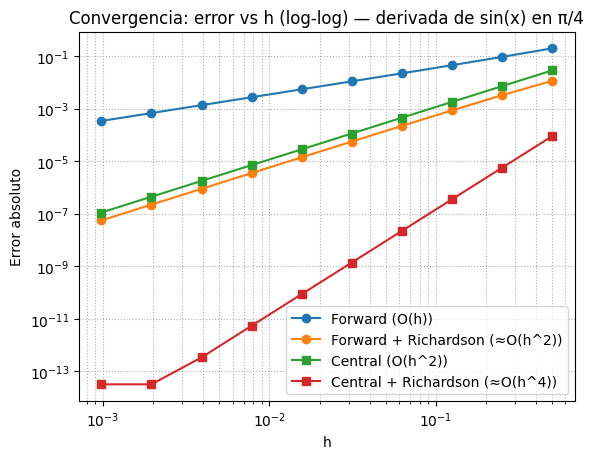

In [13]:
plt.figure()
plt.loglog(df['h'], df['err_forward'], marker='o', label='Forward (O(h))')
plt.loglog(df['h'], df['err_forward_r'], marker='o', label='Forward + Richardson (≈O(h^2))')
plt.loglog(df['h'], df['err_central'], marker='s', label='Central (O(h^2))')
plt.loglog(df['h'], df['err_central_r'], marker='s', label='Central + Richardson (≈O(h^4))')
plt.xlabel('h')
plt.ylabel('Error absoluto')
plt.title('Convergencia: error vs h (log-log) — derivada de sin(x) en π/4')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()
